In [1]:
import datetime as dt
import matplotlib.pyplot as plt
from matplotlib import style
from mpl_finance import candlestick_ohlc
import matplotlib.dates as mdates
import pandas as pd
import pandas_datareader.data as web
import bs4 as bs
import pickle
import requests
import os
import numpy as np
from collections import Counter
from sklearn import svm, cross_validation, neighbors
from sklearn.ensemble import VotingClassifier, RandomForestClassifier

C:\Users\user\Anaconda3\lib\site-packages\sklearn\cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)
C:\Users\user\Anaconda3\lib\site-packages\sklearn\ensemble\weight_boosting.py:29: DeprecationWarning: numpy.core.umath_tests is an internal NumPy module and should not be imported. It will be removed in a future NumPy release.
  from numpy.core.umath_tests import inner1d


In [2]:
style.use('ggplot')

In [3]:
def save_sp500_tickers():
    resp = requests.get('https://en.wikipedia.org/wiki/List_of_S%26P_500_companies')
    soup = bs.BeautifulSoup(resp.text, 'lxml')
    table = soup.find('table', {'class': 'wikitable sortable'})
    tickers = []
    for row in table.findAll('tr')[1:]:
        ticker = row.findAll('td')[0].text
        tickers.append(ticker)
    with open('sp500tickers.pickle','wb') as f:
        pickle.dump(tickers, f)
    return tickers
save_sp500_tickers()

ConnectionError: HTTPSConnectionPool(host='en.wikipedia.org', port=443): Max retries exceeded with url: /wiki/List_of_S%26P_500_companies (Caused by NewConnectionError('<urllib3.connection.VerifiedHTTPSConnection object at 0x00000222376374E0>: Failed to establish a new connection: [Errno 11001] getaddrinfo failed',))

In [4]:
def get_data_from_yahoo(reload_sp500=False):
    if reload_sp500:
        tickets = save_sp500_tickers()
    else:
        with open('sp500tickers.pickle','rb') as f:
            tickers = pickle.load(f)
    if not os.path.exists('stock_dfs'):
        os.makedirs('stock_dfs')
    start = dt.datetime(2000,1,1)
    end = dt.datetime(2018,12,7)
    
    for ticker in tickers:
        if not os.path.exists('stock_dfs/{}.csv'.format(ticker)):
            df = web.DataReader(ticker, 'yahoo', start, end)
            df.to_csv('stock_dfs/{}.csv'.format(ticker))
        else:
            print('Already have{}'.format(ticker))
#get_data_from_yahoo()

In [5]:
##COMBINING S$P 500 INTO 1

In [6]:
def compile_data():
    with open('sp500tickers.pickle','rb') as f:
        tickers = pickle.load(f)
    main_df = pd.DataFrame()
    
    for count, ticker in enumerate(tickers):
        df  = pd.read_csv('stock_dfs/{}.csv'.format(ticker))
        df.set_index('Date', inplace=True)
        
        df.rename(columns={'Adj Close': ticker}, inplace=True)
        df.drop(['Open', 'High', 'Low', 'Close', 'Volume'], 1, inplace=True)
        
        if main_df.empty:
            main_df = df
        else:
            main_df = main_df.join(df, how='outer')
            
        #if count % 10 ==0:
        #    print (count)
            
    print (main_df.head())
    main_df.to_csv('sp500_joined_closes.csv')
    
#compile_data()

In [7]:
##CORRELATION

           MMM       ABT      ABBV      ABMD       ACN      ATVI      ADBE  \
MMM   1.000000  0.960182  0.928158  0.798501  0.977861  0.943943  0.900816   
ABT   0.960182  1.000000  0.931810  0.822022  0.978201  0.922750  0.904860   
ABBV  0.928158  0.931810  1.000000  0.888364  0.936319  0.919044  0.932527   
ABMD  0.798501  0.822022  0.888364  1.000000  0.864327  0.911905  0.966583   
ACN   0.977861  0.978201  0.936319  0.864327  1.000000  0.955653  0.930516   

           AMD       AAP       AES    ...         WLTW      WYNN       XEL  \
MMM  -0.248964  0.859516 -0.238560    ...     0.939938  0.720044  0.968059   
ABT  -0.296053  0.879498 -0.204198    ...     0.900300  0.765085  0.961909   
ABBV  0.745101  0.180917  0.306876    ...     0.933402  0.234558  0.853968   
ABMD  0.074041  0.609957 -0.026259    ...     0.778061  0.492558  0.801315   
ACN  -0.128813  0.866058  0.087285    ...     0.924842  0.721392  0.982182   

           XRX      XLNX       XYL       YUM       ZBH      ZI

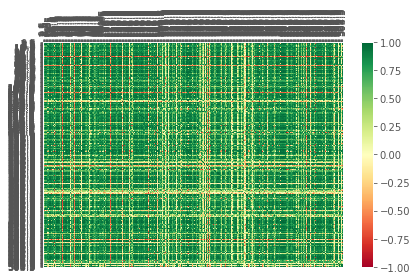

In [9]:
def visualize_data():
    df=pd.read_csv('sp500_joined_closes.csv')
    #df['AAPL'].plot()
    #plt.show()
    
    df_corr = df.corr()
    print(df_corr.head())
    
    data = df_corr.values
    
    fig = plt.figure()
    ax = fig.add_subplot(1,1,1)
    
    heatmap = ax.pcolor(data, cmap=plt.cm.RdYlGn)
    fig.colorbar(heatmap)
    
    ax.set_xticks(np.arange(data.shape[0]) + 0.5, minor=False)
    ax.set_yticks(np.arange(data.shape[1]) + 0.5, minor=False)
    ax.invert_yaxis()
    ax.xaxis.tick_top()
    
    column_labels = df_corr.columns
    row_labels = df_corr.index
    
    #ax.set_xtickslabels(column_labels)
    #ax.set_ytickslabels(row_labels)
    plt.xticks(rotation=90)
    heatmap.set_clim(-1, 1)
    plt.tight_layout()
    plt.show()
    
    
visualize_data()

In [10]:
def process_data_for_labels(ticker):
    hm_days = 7
    df=pd.read_csv('sp500_joined_closes.csv', index_col=0)
    tickers = df.columns.values.tolist()
    df.fillna(0, inplace=True)
    
    for i in range(1, hm_days+1):
        df['{}_{}d'.format(ticker, i)] = (df[ticker].shift(-i)- df[ticker]) / df[ticker]
        
    df.fillna(0, inplace=True)
    return tickers, df
#process_data_for_labels('XOM')

In [11]:
def buy_sell_hold(*args):
    cols = [c for c in args]
    requirement = 0.02
    for col in cols:
        if col> requirement:
            return 1
        if col < -requirement:
            return -1
    return 0


In [12]:
def extract_featuresets(ticker):
    tickers, df = process_data_for_labels(ticker)
    
    df['{}_target'.format(ticker)] = list(map (buy_sell_hold,
                                                df['{}_1d'.format(ticker)],
                                                df['{}_2d'.format(ticker)],
                                                df['{}_3d'.format(ticker)],
                                                df['{}_4d'.format(ticker)],
                                                df['{}_5d'.format(ticker)],
                                                df['{}_6d'.format(ticker)],
                                                df['{}_7d'.format(ticker)],
                                              ))
    vals = df['{}_target'.format(ticker)].values.tolist()
    str_vals = [str(i) for i in vals]
    print('Data Spread:', Counter(str_vals))
    df.fillna(0, inplace=True)
    
    df = df.replace([np.inf, -np.inf], np.nan)
    df.dropna(inplace=True)
    
    df_vals=df[[ticker for ticker in tickers]].pct_change()
    df_vals = df_vals.replace([np.inf, -np.inf], 0)
    df_vals.fillna(0, inplace=True)
    
    X = df_vals.values
    y = df['{}_target'.format(ticker)].values
    
    return X, y, df
#extract_featuresets('XOM')

In [14]:
def do_ml(ticker):
    X,y,df = extract_featuresets(ticker)
    X_train, X_test, y_train, y_test = cross_validation.train_test_split(X, y, test_size = 0.25)
#    clf = neighbors.KNeighborsClassifier()
    clf = VotingClassifier([('lsvc', svm.LinearSVC()),
                           ('knn', neighbors.KNeighborsClassifier()),
                           ('rfor', RandomForestClassifier())])
    clf.fit(X_train, y_train)
    confidence= clf.score(X_test, y_test)
    predictions = clf.predict(X_test)
    print('Accuracy:', confidence)
    print('Predicted Spread:', Counter(predictions))
    return confidence

do_ml('BAC')

Data Spread: Counter({'1': 2021, '-1': 1834, '0': 909})


C:\Users\user\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


Accuracy: 0.4256926952141058
Predicted Spread: Counter({1: 609, -1: 557, 0: 25})


C:\Users\user\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


0.4256926952141058